In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import urllib.request
import xml.etree.ElementTree as ET
import plotly.graph_objects as go
import plotly.io as pio
import psycopg2
import seaborn as sns
import datetime

from datetime import datetime
from pymongo import MongoClient

In [31]:
# Connecting to MongoDB
mongo_client = MongoClient("mongodb://localhost:27017/")
project_db = mongo_client["projectdb"]

In [32]:
# Reading unemployment-statistics data
unemployment_statistics_url = "https://data.ny.gov/api/views/dh9m-5v4d/rows.json?accessType=DOWNLOAD"
unemployment_statistics_response = urllib.request.urlopen(unemployment_statistics_url)
unemployment_statistics_data = json.loads(unemployment_statistics_response.read())

# inserting into mongoDB
unemployment_statistics_collection = project_db["unemployment_statistics"]
# deleting extising data
unemployment_statistics_collection.drop()

cols = unemployment_statistics_data["meta"]["view"]["columns"]
cols_without_minus_one = filter(lambda val: val["id"] != -1, cols)
unemployment_statistics_cols = list(cols_without_minus_one)

unemployment_statistics_cols_others_len = len(list(filter(lambda val: val["id"] == -1, cols)))

for row in unemployment_statistics_data["data"]:
    db_row = {}
    for col_meta in unemployment_statistics_cols:
        data_value_index = int(col_meta["position"]) + unemployment_statistics_cols_others_len - 1
        db_row[col_meta["fieldName"]] = row[data_value_index]
    unemployment_statistics_collection.insert_one(db_row)

print("Inserted unemployment_statistics document count: ", unemployment_statistics_collection.count_documents({}))

Inserted unemployment_statistics document count:  1689


In [4]:
# Reading covid_cases
covid_cases_url = "https://data.cityofnewyork.us/api/views/rc75-m7u3/rows.json?accessType=DOWNLOAD"
covid_cases_response = urllib.request.urlopen(covid_cases_url)
covid_cases_data = json.loads(covid_cases_response.read())

# inserting into mongoDB
covid_cases_collection = project_db["covid_cases"]
# deleting extising data
covid_cases_collection.drop()


covid_cases_cols = list(filter(lambda val: val["id"] != -1, covid_cases_data["meta"]["view"]["columns"]))
covid_cases_cols_others_len = len(list(filter(lambda val: val["id"] == -1, covid_cases_data["meta"]["view"]["columns"])))


for row in covid_cases_data["data"]:
    db_row = {}
    for col in covid_cases_cols:
        db_row[col["fieldName"].lower()] = row[int(col["position"]) + covid_cases_cols_others_len - 1]
    covid_cases_collection.insert_one(db_row)

print("Inserted air_quality document count: ",covid_cases_collection.count_documents({}))

Inserted air_quality document count:  1022


In [5]:
# Reading air_quality
air_quality_url = "https://data.cityofnewyork.us/api/views/c3uy-2p5r/rows.xml?accessType=DOWNLOAD"
air_quality_response = urllib.request.urlopen(air_quality_url)
air_quality_xml = ET.parse(air_quality_response)
air_quality_xml_root = air_quality_xml.getroot()
air_quality_data = []

# inserting into mongoDB
air_quality_collection = project_db["air_quality"]
# deleting extising data
air_quality_collection.drop()

for row in air_quality_xml_root[0].findall('row'):
    air_quality_data_row = {}
    for elem in row.iter():
        if elem is not row:
            key = elem.tag.lower()
            value = elem.text
            #{"key":"value"}             
            air_quality_data_row[key] = value
    if len(air_quality_data_row) != 0:
        air_quality_collection.insert_one(air_quality_data_row)
print("Inserted air_quality document count: ", air_quality_collection.count_documents({}))

Inserted air_quality document count:  16122


In [ ]:
#  MongoDB collections
# 1. unemployment_statistics_collection
# 2. covid_cases_collection
# 3. air_quality_collection

In [33]:
# creating table in postgress
conn = psycopg2.connect(database="postgres",
                        host="localhost",
                        user="postgres",
                        password="admin",
                        port="5432")

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS unemployment_statistics;CREATE TABLE unemployment_statistics (unemployment_statistics_id serial PRIMARY KEY, date_of_interest TIMESTAMP NOT NULL, area VARCHAR(255), labor_force BIGINT, employed BIGINT, unemployed BIGINT, unemployment_rate REAL);")
cursor.execute("DROP TABLE IF EXISTS covid_cases;CREATE TABLE covid_cases (covid_cases_id serial PRIMARY KEY, date_of_interest TIMESTAMP NOT NULL, case_count INTEGER);")
cursor.execute("DROP TABLE IF EXISTS air_quality;CREATE TABLE air_quality (air_quality_id serial PRIMARY KEY, date_of_interest TIMESTAMP NOT NULL, data_value REAL);")

conn.commit()

In [34]:
unemployment_statistics_collection = project_db["unemployment_statistics"]
query = """INSERT INTO unemployment_statistics 
    (date_of_interest, area, labor_force, employed, unemployed, unemployment_rate) 
    VALUES (%s,%s,%s,%s,%s,%s)"""
cursor = conn.cursor()
for row in unemployment_statistics_collection.find():
    date = row["year"]+"-"+row["month"]+"-01"
    cursor.execute(query, (date, row["area"], row["labor_force"], row["employed"], 
                           row["unemployed"], row["unemployment_rate"]))
cursor.close()
conn.commit()

In [35]:
covid_cases_collection = project_db["covid_cases"]

cursor = conn.cursor()
for row in covid_cases_collection.find():
    date = row["date_of_interest"]
    cursor.execute("INSERT INTO covid_cases (date_of_interest, case_count) VALUES (%s,%s)", 
                   (date, row["case_count"]))
cursor.close()
conn.commit()

In [36]:
air_quality_collection = project_db["air_quality"]

cursor = conn.cursor()
for row in air_quality_collection.find():
    date = row["start_date"]
    cursor.execute("INSERT INTO air_quality (date_of_interest, data_value) VALUES (%s,%s)", 
                   (date, row["data_value"]))
cursor.close()
conn.commit()

In [37]:
cursor = conn.cursor();
query = """
SELECT date_of_interest, AVG(unemployment_rate)
    FROM unemployment_statistics 
    WHERE date_of_interest >= '2020-01-01' and date_of_interest < '2021-01-01'
    GROUP BY date_of_interest ORDER BY date_of_interest ASC 

"""

    
cursor.execute(query)
unemployment_rate_data = cursor.fetchall()
cursor.close()

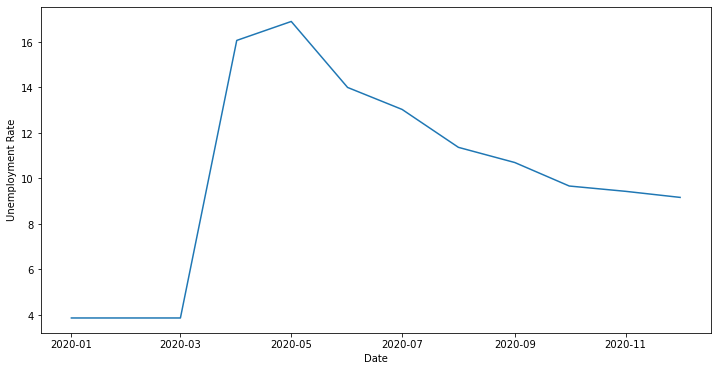

In [38]:

unemployment_rate_df = pd.DataFrame(data = unemployment_rate_data,
                                   columns=["Date",
                                            "Unemployment Rate"])
# x_dates = unemployment_rate_df['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()

fig, ax = plt.subplots(figsize = (12,6))

fig = sns.lineplot(
    data=unemployment_rate_df, 
    x="Date", 
    y="Unemployment Rate",
    estimator=sum,
    ax=ax
)




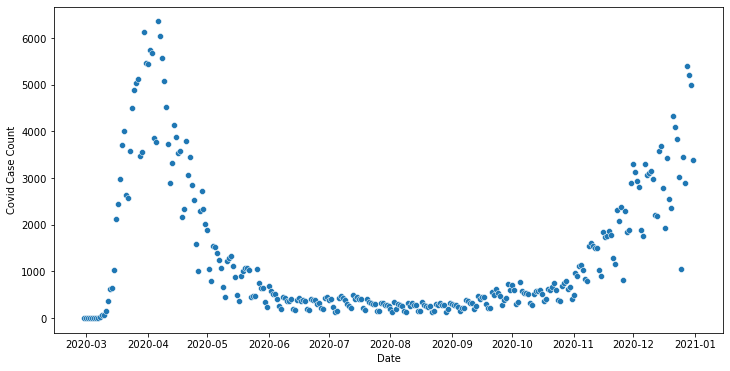

In [39]:
cursor = conn.cursor();
cursor.execute("""SELECT date_of_interest, avg(case_count) 
    FROM covid_cases  
    WHERE date_of_interest >= '2020-01-01' and date_of_interest < '2021-01-01'
    group by date_of_interest order by date_of_interest asc""")
covid_cases_data = cursor.fetchall()
cursor.close()


covid_cases_data_df = pd.DataFrame(data = covid_cases_data,
                                   columns=["Date",
                                            "Covid Case Count"])
fig, ax = plt.subplots(figsize = (12,6))

fig = sns.scatterplot(data = covid_cases_data_df, 
                   x="Date", 
                   y="Covid Case Count",
                   ax=ax
                  )



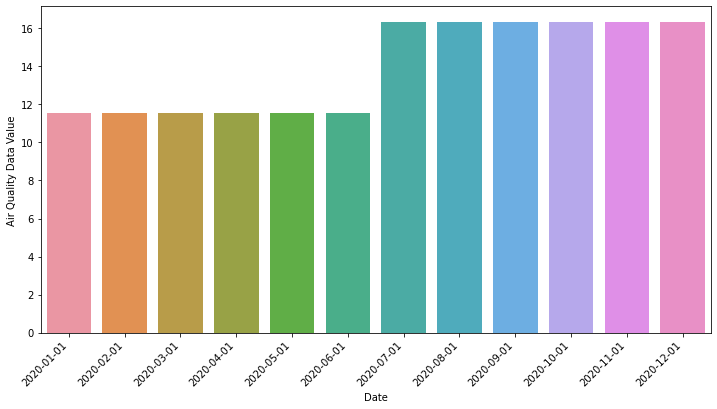

In [43]:
cursor = conn.cursor();
query = """
SELECT date_of_interest, avg(data_value) 
    FROM air_quality
    WHERE date_of_interest >= '2020-01-01' and date_of_interest < '2022-01-01'
    GROUP BY  date_of_interest order by date_of_interest asc
"""
cursor.execute(query)
air_quality_data = cursor.fetchall()
cursor.close()


air_quality_data_modified = []
for x in range(12):
    date = datetime(2020, x+1, 1)
    if x < 6:
        key, value = air_quality_data[0]
        air_quality_data_modified.append((date, value))
    else:
        key, value = air_quality_data[1]
        air_quality_data_modified.append((date, value))

air_quality_data_df = pd.DataFrame(data = air_quality_data_modified,
                                   columns=["Date", "Air Quality Data Value"])
fig, ax = plt.subplots(figsize = (12,6))

fig = sns.barplot(data = air_quality_data_df, x="Date", y="Air Quality Data Value", ax=ax)

x_dates = air_quality_data_df['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
arr = ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')


In [50]:
# grouping data based on  month
air_quality_data_df = air_quality_data_df.groupby(pd.PeriodIndex(air_quality_data_df['Date'], freq="M"))["Air Quality Data Value"].mean().reset_index()
covid_cases_data_df = covid_cases_data_df.groupby(pd.PeriodIndex(covid_cases_data_df['Date'], freq="M"))["Covid Case Count"].mean().reset_index()
unemployment_rate_df = unemployment_rate_df.groupby(pd.PeriodIndex(unemployment_rate_df['Date'], freq="M"))["Unemployment Rate"].mean().reset_index()

# merging all data
covid_cases_air_quality_df = pd.merge(air_quality_data_df, covid_cases_data_df, how="outer", on ="Date")
all_data = pd.merge(covid_cases_air_quality_df, unemployment_rate_df, how="left", on ="Date")

# filling emtpy value with 0
all_data["Air Quality Data Value"] = all_data["Air Quality Data Value"].fillna(0)
all_data["Covid Case Count"] = all_data["Covid Case Count"].fillna(0)
all_data["Unemployment Rate"] = all_data["Unemployment Rate"].fillna(0)

# 01-2020 > 01-01-2020
all_data['Date'] = all_data['Date'].dt.strftime('%Y-%m-01')




C:\Users\karthi\AppData\Local\Temp\ipykernel_32160\625260525.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  arr = ax1.set_xticklabels(labels=x_dates, rotation=45, ha='right')


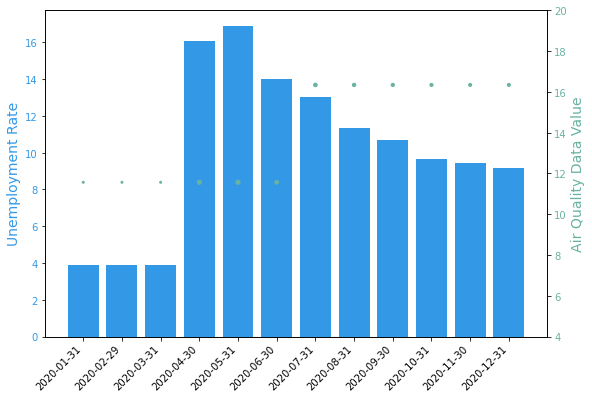

In [48]:
fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx()  
ax2.set_ylim(4, 20);

COLOR_UNEMPLOYMENT = "#3399e6"
COLOR_AIR_QUALITY = "#69b3a2"

#left side y axis
ax1.bar(all_data["Date"], all_data["Unemployment Rate"], color=COLOR_UNEMPLOYMENT) 
ax1.set_ylabel("Unemployment Rate", color=COLOR_UNEMPLOYMENT, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_UNEMPLOYMENT)
x_dates = unemployment_rate_df['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
arr = ax1.set_xticklabels(labels=x_dates, rotation=45, ha='right')

#right side y axis
ax2.scatter(all_data["Date"], all_data["Air Quality Data Value"], 
            s = all_data["Unemployment Rate"], color=COLOR_AIR_QUALITY) 
ax2.set_ylabel("Air Quality Data Value", color=COLOR_AIR_QUALITY, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_AIR_QUALITY)